# DS4G - Geospatial Analysis, Accessing GEE

### In this kernal, I am reading the NO2 column density value from tiff image and also from GEE directly. May be few cells are showing error , But they are showing output in my kernal. Please replace your ee user secret value in cell 13 to access ee.

## About Google Earth Engine


Google's mission is to organize the world's information and make it universally accessible and useful. In line with this mission, Earth Engine organizes geospatial information and makes it available for analysis. More generally, Google strives to make the world a better place through the use of technology.

**About Google Earth Engine

Google Earth Engine is a cloud-based platform for planetary-scale environmental data analysis. **

### Load all Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
import folium 
import seaborn as sns

**Step 1: Explore the power plant data**

In [ ]:
def plot_points_on_map(dataframe,latitude_value,longitude_value,zoom):
    #df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    fuelColor = {'Coal': 'darkred',
                 'Oil': 'black',
                 'Gas': 'lightgray',
                 'Hydro': 'lightblue',
                 'Solar': 'orange',
                 'Wind': 'green'
                }
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(dataframe)):
        fuel = dataframe['primary_fuel'][i]
        lat = dataframe['latitude'][i]
        lon = dataframe['longitude'][i]
        name = dataframe['name'][i]
        popup = "{}, geolocation : [{},{}], {} ".format(fuel,lat, lon, name)
        color = fuelColor[fuel]
        folium.Marker([lat,lon],
                      popup=popup,
                      icon=folium.Icon(color=color, icon_color='white', icon='bolt', prefix='fa')
                     ).add_to(plot)  
    

    return(plot)

    

In [ ]:
'''
def plot_points_on_map(dataframe,begin_index,end_index,latitude_column,latitude_value,longitude_column,longitude_value,zoom):
    df = dataframe[begin_index:end_index]
    location = [latitude_value,longitude_value]
    
    plot = folium.Map(location=location,zoom_start=zoom)
    for i in range(0,len(df)):
        popup = folium.Popup(str(df.primary_fuel[i:i+1]))
        folium.Marker([df[latitude_column].iloc[i],df[longitude_column].iloc[i]],popup=popup).add_to(plot)
    return(plot)
'''
def overlay_image_on_puerto_rico(file_name,band_layer,lat,lon,zoom):
    band = rio.open(file_name).read(band_layer)
    m = folium.Map([lat, lon], zoom_start=zoom)
    folium.raster_layers.ImageOverlay(
        image=band,
        bounds = [[18.6,-67.3,],[17.9,-65.2]],
        colormap=lambda x: (1, 0, 0, x),
    ).add_to(m)
    return m

def plot_scaled(file_name):
    vmin, vmax = np.nanpercentile(file_name, (5,95))  # 5-95% stretch
    img_plt = plt.imshow(file_name, cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()

def split_column_into_new_columns(dataframe,column_to_split,new_column_one,begin_column_one,end_column_one):
    for i in range(0, len(dataframe)):
        dataframe.loc[i, new_column_one] = dataframe.loc[i, column_to_split][begin_column_one:end_column_one]
    return dataframe

In [ ]:
pd.set_option('max_columns', 30)

In [ ]:
power_plants = pd.read_csv('/kaggle/input/ds4g-environmental-insights-explorer/eie_data/gppd/gppd_120_pr.csv')

power_plants.head(5)

### Step 2 : Plot the PP data

In [ ]:
power_plants = split_column_into_new_columns(power_plants,'.geo','latitude',50,66)
power_plants = split_column_into_new_columns(power_plants,'.geo','longitude',31,48)
power_plants['latitude'] = power_plants['latitude'].astype(float)
a = np.array(power_plants['latitude'].values.tolist()) # 18 instead of 8
power_plants['latitude'] = np.where(a < 10, a+10, a).tolist() 

**The dataset gppd_120_pr.csv contains 24 columns, we include only those are required as of now**

In [ ]:
power_plants.columns

In [ ]:
power_plants_df = power_plants[['capacity_mw', 
                               'commissioning_year', 
                               'country', 'country_long', 
                               'estimated_generation_gwh', 
                               'generation_gwh_2013', 'generation_gwh_2014', 
                               'generation_gwh_2015', 'generation_gwh_2016',  
                               'generation_gwh_2017', 'geolocation_source', 
                               'source', 'name', 
                               'other_fuel1', 'other_fuel2', 'other_fuel3', 
                               'owner', 'primary_fuel','.geo']]

In [ ]:
power_plants_df = split_column_into_new_columns(power_plants_df,'.geo','latitude',50,66)
power_plants_df = split_column_into_new_columns(power_plants_df,'.geo','longitude',31,48)
power_plants_df['latitude'] = power_plants_df['latitude'].astype(float)
power_plants_df['longitude'] = power_plants_df['longitude'].astype(float)


In [ ]:
power_plants_df.head(2)

In [ ]:
lat=18.200178; lon=-66.664513
plot_points_on_map(power_plants_df,lat,lon,9)

In [ ]:
power_plants_df.isnull().sum()

### Step 3:  To Connect with Earth Engine Data 

In [ ]:
import ee
from kaggle_secrets import UserSecretsClient
from google.oauth2.credentials import Credentials
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("isis")

In [ ]:
ee.Authenticate()

In [ ]:
!cat ~/.config/earthengine/credentials

In [ ]:
#user_secret = "" # Your user secret, defined in the add-on menu of the notebook editor
#refresh_token = UserSecretsClient().get_secret(user_secret)
credentials = Credentials(
        None,
        refresh_token=secret_value_0,
        token_uri=ee.oauth.TOKEN_URI,
        client_id=ee.oauth.CLIENT_ID,
        client_secret=ee.oauth.CLIENT_SECRET,
        scopes=ee.oauth.SCOPES)
#ee.Initialize(credentials=credentials)

In [ ]:
ee.Initialize()

In [ ]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  # https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

def plot_ee_data_on_map(dataset,column,begin_date,end_date,minimum_value,maximum_value,latitude,longitude,zoom):
    # https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb
    folium.Map.add_ee_layer = add_ee_layer
    vis_params = {
      'min': minimum_value,
      'max': maximum_value,
      'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}
    my_map = folium.Map(location=[latitude,longitude], zoom_start=zoom, height=500)
    s5p = ee.ImageCollection(dataset).filterDate(
        begin_date, end_date)
    my_map.add_ee_layer(s5p.first().select(column), vis_params, 'Color')
    my_map.add_child(folium.LayerControl())
    display(my_map)

### Step 4: Organize the data from the image files

#### Need to extract the date details from the file names, GFS , GLDAS contains single date with time, whereas s5p contains both starting and ending datetime

In [ ]:
from datetime import datetime
data_path = '/kaggle/input/ds4g-environmental-insights-explorer'
gldas_files = os.listdir(data_path + '/eie_data/gldas')

In [ ]:
def convert_df( dff, j):
    name, ext = dff['filename'][j].split('.')
    #print (name, ext)
    df_name = name[0:3]
    split_str = name.split('_')
    
    if df_name in 'gld' :
        dff['dataset'][j] = split_str[0]
        dff['date_from'][j] = split_str[1]+split_str[2]
        dff['date_to'][j] = split_str[1]+split_str[2]
    elif df_name in 'gfs':
        dff['dataset'][j] = split_str[0]
        dff['date_from'][j] = split_str[1]
        dff['date_to'][j] = split_str[1]
    elif df_name in 's5p':
        dff['dataset'][j] = split_str[0]+'_'+split_str[1]
        dff['date_from'][j] = split_str[2]
        dff['date_to'][j] = split_str[3]
        

In [ ]:
df_gldas = pd.DataFrame(gldas_files)
df_gldas.rename(columns={0:'filename'}, inplace=True)
df_gldas['dataset'] = ""
df_gldas['date_from']=""
df_gldas['date_to']=""

for i in range(df_gldas.shape[0]):
    convert_df(df_gldas, i)
df_gldas.head()   

In [ ]:
gfs_files = os.listdir(data_path + '/eie_data/gfs')
df_gfs = pd.DataFrame(gfs_files)
df_gfs.rename(columns={0:'filename'}, inplace=True)
df_gfs['dataset'] = ""
df_gfs['date_from']=""
df_gfs['date_to']=""

for i in range(df_gfs.shape[0]):
    convert_df(df_gfs, i)
df_gfs.head(5)  

In [ ]:
s5p_files = os.listdir(data_path + '/eie_data/s5p_no2')
df_s5p_no2 = pd.DataFrame(s5p_files)
df_s5p_no2.rename(columns={0:'filename'}, inplace=True)
df_s5p_no2['dataset'] = ""
df_s5p_no2['date_from']=""
df_s5p_no2['date_to']=""

for i in range(df_s5p_no2.shape[0]):
    convert_df(df_s5p_no2, i)
df_s5p_no2.head(5)  



### Step 5: Lets focus on the image details one by one

### Lets concentrate on a single geolocation

### Using the location from PP csv data, checking the NO2 column density only for Vieques (which is a Oil power plant) in the map

In [ ]:
dataset = "COPERNICUS/S5P/OFFL/L3_NO2"
column = 'NO2_column_number_density'
begin_date = '2019-05-04'
end_date = '2019-05-10'
minimum_value = 0
maximum_value = 0.0002
latitude = 18.142901
longitude = -65.444001
zoom = 11
plot_ee_data_on_map(dataset,column,begin_date,end_date,minimum_value,maximum_value,latitude,longitude,zoom)

### Lets draw the first image from s5p_no2 files

In [ ]:
image = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20190504T165553_20190510T183608.tif'
latitude=18.142901; longitude=-65.444001
overlay_image_on_puerto_rico(image,band_layer=1,lat=latitude,lon=longitude,zoom=8)


### Reading No2 column density value from the given image [for first record in s5p_no2]

In [ ]:
import tifffile as tiff
mean_no2_emission = np.mean(tiff.imread(image)[:, :, 0 : 1])
print ("{:.8f}".format(mean_no2_emission))
#print (np.sum(tiff.imread(image)[:, :, 0 : 1]))

### From the tiff image we  get  0.00004196   as mean NO2 column density value

### Data taken from GEE for the geolocation of Vieques latitude=18.142901; longitude=-65.444001 for the above dates(Refer gpgd_120.csv for coordinates and dates from df_s5p_no2

![](http://)

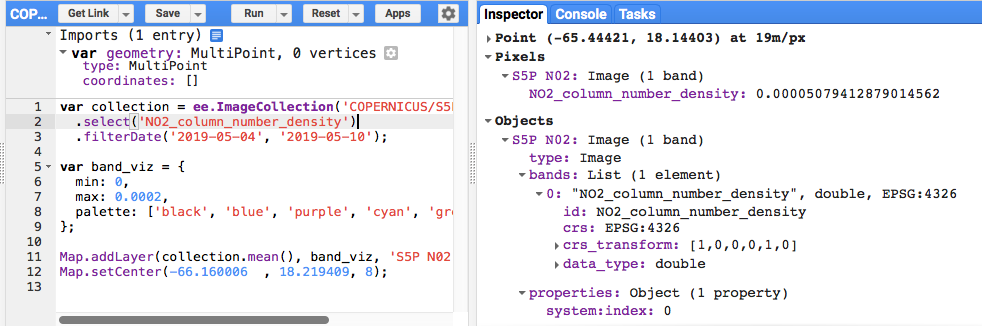

**The above reading shows 0.0000507 as No2 density**

### Lets draw the second image from the folder

In [ ]:
image2 = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20190302T163011_20190308T182209.tif'
latitude=18.142901; longitude=-65.444001
overlay_image_on_puerto_rico(image2,band_layer=1,lat=latitude,lon=longitude,zoom=8)

**This is empty, so there is no recordings for given date range **

### Calculate the No2 density for the second image

In [ ]:
mean_no2_emission = np.mean(tiff.imread(image2)[:, :, 0 : 1])
mean_no2_emission

### From GEE, NO2 density data for Date for 02-03-2019 to 08-03-2019  

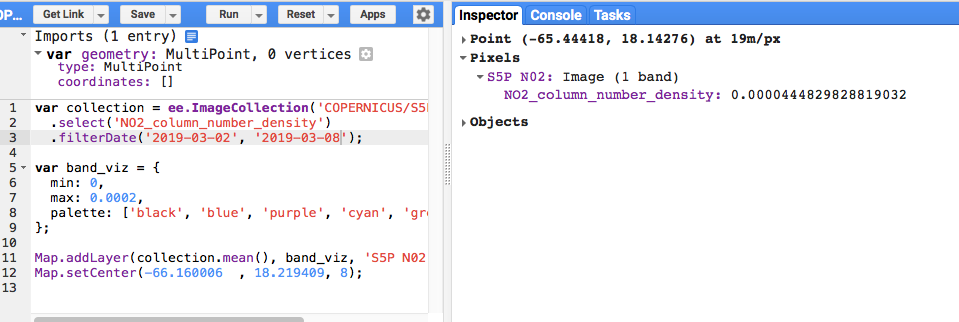

### Do we suppose to replace the NaN values with these for analysis???

### Lets plot the third image and check

In [ ]:
image3 = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20181004T162458_20181010T175419.tif'
latitude=18.142901; longitude=-65.444001
overlay_image_on_puerto_rico(image3,band_layer=1,lat=latitude,lon=longitude,zoom=8)


In [ ]:
mean_no2_emission = np.mean(tiff.imread(image3)[:, :, 0 : 1])
mean_no2_emission

#### Even this image does not have reading for the date range

### Whereas the GEE shows value for the same dates 2018-10-04 to 2018-10-10

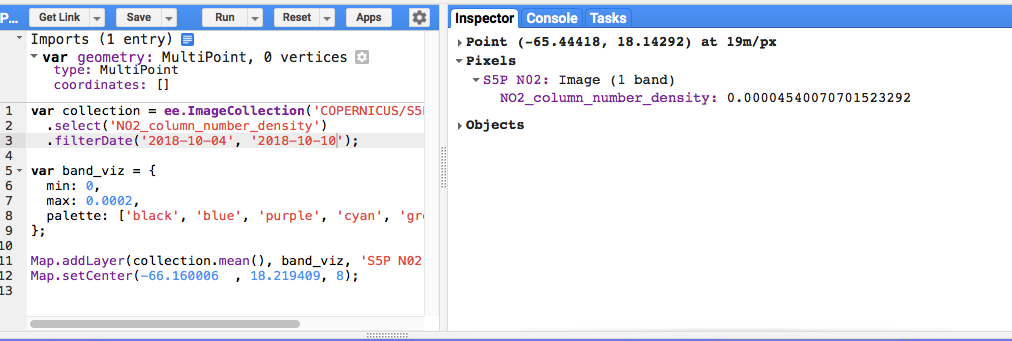

### GEE data shows 0.0000454 as NO2 density

### Fourth Image

In [ ]:
image4 = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20180807T161744_20180813T174606.tif'
latitude=18.142901; longitude=-65.444001
overlay_image_on_puerto_rico(image4,band_layer=1,lat=latitude,lon=longitude,zoom=8)


In [ ]:
mean_no2_emission_image4 = np.mean(tiff.imread(image4)[:, :, 0 : 1])
print ("{:.8f}".format(mean_no2_emission_image4))

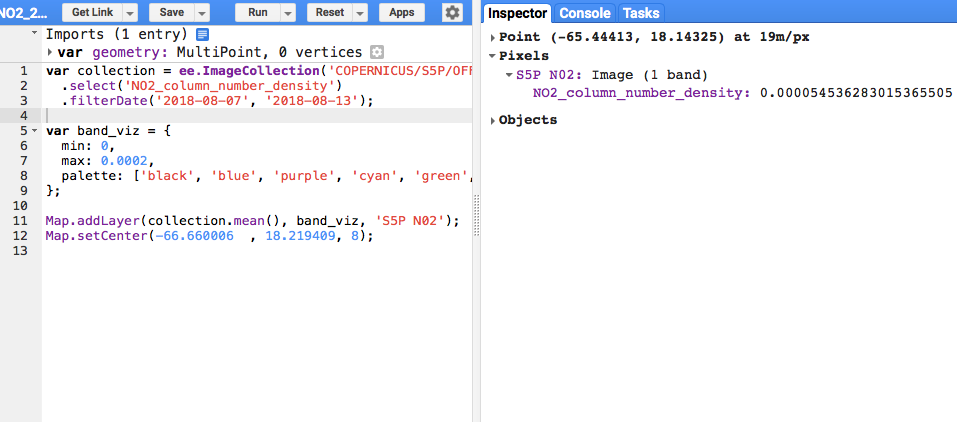

### Sample SO2 column density from _OFFL_SO2 dataset

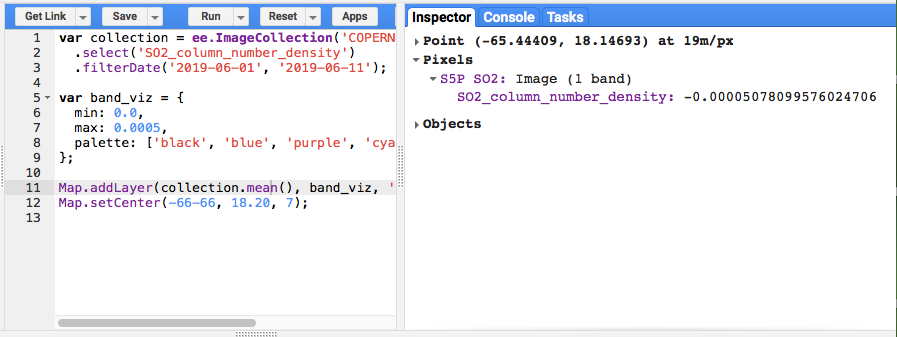

### Step 6: Emission Factor Calculation

E = A x EF x (1-ER/100)
where:

E = emissions; A = activity rate; EF = emission factor, and ER =overall emission reduction efficiency, %

therefore

EF = E / [A x (1-ER/100)]
To simplify things a bit, I'll reduce that equation to: EF = E / A

Simplified Emissions Factor = Emissions / Activity Rate
Which again can be similified to the following:

Simplified Emissions Factor = (Measure of NO2 emissions) / (Quanity of electricity generated)

In [ ]:
power_plants_df = power_plants_df.sort_values('capacity_mw',ascending=False).reset_index()
power_plants_df[['name','latitude','longitude','primary_fuel','capacity_mw','estimated_generation_gwh']][29:30]
quantity_of_electricity_generated = power_plants_df['estimated_generation_gwh'][29:30].values
print('Quanity of Electricity Generated: ', quantity_of_electricity_generated)

In [ ]:
Emission_Factor = float(mean_no2_emission_image4/quantity_of_electricity_generated)
#Emission_Factor

In [ ]:
print ("Emission factor for Vieques {:.12f} mol * h / m^2 * gw".format(Emission_Factor))

In [ ]:
'''
harpconvert --format hdf5 --hdf5-compression 9
-a 'tropospheric_NO2_column_number_density_validity>50;derive(datetime_stop {time})'
S5P_OFFL_L2__NO2____20181010T074409_20181010T092539_05135_01_010100_20181016T092316.nc
grid_info.h5
'''

In [ ]:
dataset = "NOAA/GFS0P25"
column = 'temperature_2m_above_ground'
begin_date = '2018-07-08'
end_date = '2018-07-14'
minimum_value = 0
maximum_value = 50
latitude = 18.20
longitude = -66.66
zoom = 8
plot_ee_data_on_map(dataset,column,begin_date,end_date,minimum_value,maximum_value,latitude,longitude,zoom)

dataset = "NASA/GLDAS/V021/NOAH/G025/T3H"
column = 'Tair_f_inst'
begin_date = '2018-07-08'
end_date = '2018-07-14'
minimum_value = 270
maximum_value = 310
latitude = 18.20
longitude = -66.66
zoom = 8
plot_ee_data_on_map(dataset,column,begin_date,end_date,minimum_value,maximum_value,latitude,longitude,zoom)

### How to analyse image with rasterio

Analysing images using the the Rasterio module

Rasterio is a module for reading and writing several different raster formats in Python.

A raster image is an image file format that is defined by a pixel that has one or more numbers associated with it. The number defines the location, size, or color of the pixels. Raster images are commonly .BMP, .GIF, .JPEG, .PNG, and .TIFF files. Today, almost all of the images you see on the Internet and images taken by a digital camera are raster images.

Let’s start with inspecting one of the files we downloaded:

In [ ]:
image = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'
# Opening the file
raster = rio.open(image)
# All Metadata for the whole raster dataset
raster.meta


* Driver : Data Format
* dtype : data type
* width and Height : The dimensions of the image are : 475 X 148
* count : There are 12 bands in the image
* crs: Coordinate Reference Systems which refers to the way in which spatial data that represent the earth’s surface.A particular CRS can be referenced by its EPSG code (i.e.,epsg:4121). The EPSG is a structured dataset of CRS and Coordinate Transformations(link]
* transform : Affine transform (how raster is scaled, rotated, skewed, and/or translated)

Provider's Note: the names with extension _tavg are variables averaged over the past 3-hours, the names with extension '_acc' are variables accumulated over the past 3-hours, the names with extension '_inst' are instantaneous variables, and the names with '_f' are forcing variables.

In [ ]:
from rasterio.plot import show
#show(raster)
# Plotting the red channel.
show((raster, 1), cmap='pink')
show((raster, 2), cmap='pink')
show((raster, 3), cmap='pink')
show((raster, 4), cmap='pink')

In [ ]:
from rasterio.plot import show_hist

show_hist(raster, bins=4, lw=0.5, stacked=True, alpha=0.8,
histtype='stepfilled', title="Histogram")

#### Attempting to pass parameters and trying to read GEE data

In [ ]:
#/kaggle/input/ds4g-environmental-insights-explorer/eie_data
#/s5p_no2/s5p_no2_20180701T161259_20180707T175356.tif'
image = '/kaggle/input/ds4g-environmental-insights-explorer/eie_data/s5p_no2/s5p_no2_20180714T170945_20180720T185244.tif'
poi = ee.Geometry.Point(18.20, -66.66)
s2 = ee.ImageCollection(image).filterDate('2018-07-14', '2018-07-20');
#ee.ImageCollection(os.listdir(s5p_path))
#type(s2)

s2.select('tropospheric_NO2_column_number_density', 'NO2_column_number_density');
print (s2)

#### Still working !!